# Prescriptive Data, Data Science Test
**Name**: Daniel Yawitz
**Time Started**: May 10, 2016, 3pm
**Time Finished**: May 12, 2016 3pm

*The entire test took about 16 hours over the course of two days*

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Munging
## 1) Write code that loads the two weather datasets in the attached h5 file.
First, let's see what's in the HDF file

In [2]:
store = pd.HDFStore('weather.h5')
print store

<class 'pandas.io.pytables.HDFStore'>
File path: weather.h5
/weather_forecast            frame        (shape->[1,1])
/weather_history             frame        (shape->[1,1])


In [3]:
#load the two dataframes inside 'weather.h5'
forecast = pd.read_hdf('weather.h5', key = 'weather_forecast')
history = pd.read_hdf('weather.h5', key = 'weather_history')

In [4]:
history.head(1)

,conds,date,dewpti,dewptm,fog,hail,heatindexi,heatindexm,hum,icon,...,visi,vism,wdird,wdire,wgusti,wgustm,windchilli,windchillm,wspdi,wspdm
time,,,,,,,,,,,,,,,,,,,,,
2012-02-01 05:51:00+00:00,Clear,"{u'mday': u'01', u'hour': u'00', u'min': u'51'...",30.9,-0.6,0,0,-9999,-9999,43,clear,...,10.0,16.1,230,SW,-9999.0,-9999.0,-999,-999,9.2,14.8


In [5]:
forecast.head(1)

,FCTTIME,condition,dewpoint,fctcode,feelslike,heatindex,humidity,icon,icon_url,mslp,pop,qpf,sky,snow,temp,uvi,wdir,windchill,wspd,wx
time,,,,,,,,,,,,,,,,,,,,
2016-02-03 12:00:00+00:00,"{u'min_unpadded': u'0', u'civil': u'7:00 AM', ...",Chance of Rain,"{u'metric': u'4', u'english': u'40'}",12,"{u'metric': u'5', u'english': u'41'}","{u'metric': u'-9999', u'english': u'-9999'}",77,chancerain,http://icons.wxug.com/i/c/k/nt_chancerain.gif,"{u'metric': u'1023', u'english': u'30.21'}",35,"{u'metric': u'0', u'english': u'0.0'}",100,"{u'metric': u'0', u'english': u'0.0'}","{u'metric': u'8', u'english': u'46'}",0,"{u'degrees': u'126', u'dir': u'SE'}","{u'metric': u'5', u'english': u'41'}","{u'metric': u'18', u'english': u'11'}",Few Showers


## 2) Munge the weather history and weather forecast dataframes such that they contain columns that are either floats or strings.

Let's make sure the timestamps are their own columns, instead of the index. We can always reset this later.

In [6]:
history = history.reset_index()
forecast = forecast.reset_index()

Now, let's look inside `history`:

In [7]:
history.iloc[0]

time                                  2012-02-01 05:51:00+00:00
conds                                                     Clear
date          {u'mday': u'01', u'hour': u'00', u'min': u'51'...
dewpti                                                     30.9
dewptm                                                     -0.6
fog                                                           0
hail                                                          0
heatindexi                                                -9999
heatindexm                                                -9999
hum                                                          43
icon                                                      clear
metar         METAR KNYC 010551Z AUTO 23008KT 10SM CLR 12/M0...
precipi                                                -9999.00
precipm                                                -9999.00
pressurei                                                 30.01
pressurem                               

In [8]:
history.drop('date', axis=1, inplace=True) #remove the date and UTC columns, which are captured by the time index
history.drop('utcdate', axis=1, inplace=True)

Convert columns to floats and strings

In [9]:
columns_to_float_h = ['dewpti','dewptm','fog', 'hail', 'heatindexi', 'heatindexm','precipi', 'precipm', 'pressurei', 'pressurem',\
                   'rain', 'snow', 'tempi', 'tempm', 'thunder', 'tornado', 'visi', 'vism', 'wdird', 'wgusti', 'wgustm', 'windchilli', \
                   'windchillm', 'wspdi', 'wspdm']

columns_to_str_h = ['conds','icon', 'metar', 'wdire']

for col in columns_to_float_h:
    history[col] = history[col].apply(lambda x: float(x))
    
for col in columns_to_str_h:
    history[col] = history[col].apply(lambda x: str(x))
    
#There are some bad values in the 'hum' column, so handle that one separately.
new_history_hum_values = []

for i in history.hum.values:
    try:
        new_value = float(i)
    except:
        new_value = np.nan
    new_history_hum_values.append(new_value)
    
history['hum'] = new_history_hum_values

In [10]:
history.dtypes

time          datetime64[ns, UTC]
conds                      object
dewpti                    float64
dewptm                    float64
fog                       float64
hail                      float64
heatindexi                float64
heatindexm                float64
hum                       float64
icon                       object
metar                      object
precipi                   float64
precipm                   float64
pressurei                 float64
pressurem                 float64
rain                      float64
snow                      float64
tempi                     float64
tempm                     float64
thunder                   float64
tornado                   float64
visi                      float64
vism                      float64
wdird                     float64
wdire                      object
wgusti                    float64
wgustm                    float64
windchilli                float64
windchillm                float64
wspdi         

The `history` table looks clean. Let's look at `forecast`:

In [11]:
forecast.iloc[0]

time                                 2016-02-03 12:00:00+00:00
FCTTIME      {u'min_unpadded': u'0', u'civil': u'7:00 AM', ...
condition                                       Chance of Rain
dewpoint                  {u'metric': u'4', u'english': u'40'}
fctcode                                                     12
feelslike                 {u'metric': u'5', u'english': u'41'}
heatindex          {u'metric': u'-9999', u'english': u'-9999'}
humidity                                                    77
icon                                                chancerain
icon_url         http://icons.wxug.com/i/c/k/nt_chancerain.gif
mslp                {u'metric': u'1023', u'english': u'30.21'}
pop                                                         35
qpf                      {u'metric': u'0', u'english': u'0.0'}
sky                                                        100
snow                     {u'metric': u'0', u'english': u'0.0'}
temp                      {u'metric': u'8', u'english':

It looks like the `forecast` table stores metric and imperial units as dictionaries under each column. 

Let's create a new dataframe, `forecast_clean`, that mimics the format of the `history` table by splitting up those dictionaries, and renaming the columns so they're consistent.

In [12]:
forecast_clean = forecast[['time', 'humidity', 'pop', 'icon', 'wx']] #start with these columns, which are already the right format

forecast_clean['dewpti'] = forecast['dewpoint'].apply(lambda x: x['english'])
forecast_clean['dewptm'] = forecast['dewpoint'].apply(lambda x: x['metric'])

forecast_clean['heatindexi'] = forecast['heatindex'].apply(lambda x: x['english'])
forecast_clean['heatindexm'] = forecast['heatindex'].apply(lambda x: x['metric'])

forecast_clean['pressurei'] = forecast['mslp'].apply(lambda x: x['english']) #'mslp' stands for 'Mean Sea Level Pressure'
forecast_clean['pressurem'] = forecast['mslp'].apply(lambda x: x['metric'])

forecast_clean['precipi'] = forecast['qpf'].apply(lambda x: x['english']) # 'qpf' stands for 'Quantitative Precip. Forecast'
forecast_clean['precipm'] = forecast['qpf'].apply(lambda x: x['metric'])

forecast_clean['tempi'] = forecast['temp'].apply(lambda x: x['english'])
forecast_clean['tempm'] = forecast['temp'].apply(lambda x: x['metric'])

forecast_clean['windchilli'] = forecast['windchill'].apply(lambda x: x['english'])
forecast_clean['windchillm'] = forecast['windchill'].apply(lambda x: x['metric'])

forecast_clean['wspdi'] = forecast['wspd'].apply(lambda x: x['english'])
forecast_clean['wspdm'] = forecast['wspd'].apply(lambda x: x['metric'])

forecast_clean['wdird'] = forecast['wdir'].apply(lambda x: x['degrees']) #wind direction, in degrees vs. 
forecast_clean['wdire'] = forecast['wdir'].apply(lambda x: x['dir'])

forecast_clean['snowi'] = forecast['snow'].apply(lambda x: x['english']) #unlear yet if the forecast for snow is a % likelihood or absolute amount
forecast_clean['snowm'] = forecast['snow'].apply(lambda x: x['metric'])


Make sure all the columns are in the right format:

In [13]:
columns_to_float_f = ['humidity', 'pop', 'dewpti','dewptm', 'heatindexi', 'heatindexm', 'pressurei', 'pressurem', 'precipi', 'precipm',\
                   'tempi', 'tempm', 'wdird', 'windchilli', 'windchillm', 'wspdi', 'wspdm', 'snowi', 'snowm']
columns_to_str_f = ['wx','icon', 'wdire']

for col in columns_to_float_f:
    forecast_clean[col] = forecast_clean[col].apply(lambda x: float(x))
    
for col in columns_to_str_f:
    forecast_clean[col] = forecast_clean[col].apply(lambda x: str(x))

In [14]:
forecast_clean.dtypes

time          datetime64[ns, UTC]
humidity                  float64
pop                       float64
icon                       object
wx                         object
dewpti                    float64
dewptm                    float64
heatindexi                float64
heatindexm                float64
pressurei                 float64
pressurem                 float64
precipi                   float64
precipm                   float64
tempi                     float64
tempm                     float64
windchilli                float64
windchillm                float64
wspdi                     float64
wspdm                     float64
wdird                     float64
wdire                      object
snowi                     float64
snowm                     float64
dtype: object

## 3) Resample the data such that the timestamps occur at 15 minute intervals, on the hour (so, for example, 10:00, 10:15, 10:30, 10:45, etc).

In this case, using pandas `DataFrame.resample('15min')` function would leave us with 3/4 blank intervals, since the data was taken one every hour. After that using the pandas `refill` method would only let us forward- or back-fill those measurements with the nearest data.

Instead, I'll use a methodology that fills in those gaps with the nearest measurement:

1) Create a date range for every 15 minutes between the start and end time in `history.` 

2) Use K Neighbors to find the closest corresponding date in `history`

3) Merge the closest historical weather values into that new 15 minute interval date range.

In [15]:
start_time = history.iloc[0].time - pd.to_timedelta('6 minutes') # 2/1/2012, 5:45 pm
end_time = history.iloc[-1].time - pd.to_timedelta('6 minutes') #2/1/2016, 5:45pm

all_dates = pd.date_range(start_time, end_time, freq='15 min') #all dates is now the range of 15 min intervals
all_dates = pd.DataFrame({'time':all_dates})

In [16]:
from sklearn.neighbors import NearestNeighbors


def find_nearest(group, match, groupname):
    '''This is a function that will combine two dataframes with the same time range but different frequencies.
    
    group has a more frequent time series. match has the values you are interested in.
    
    The function uses sci-kit learn's built-in K-Nearest Neighbors function. For each time entry in 'group', the function 
    finds the nearest time value in 'match'
    
    '''
    
    nbrs = NearestNeighbors(1).fit(match[groupname].values[:, None])
    dist, ind = nbrs.kneighbors(group[groupname].values[:, None])

    group['merge_time'] = match[groupname].values[ind.ravel()]
    
#     full = group.merge(match, left_on='nearest_time', right_on='time')

    return group

In [17]:
all_dates = find_nearest(all_dates, history, 'time') #adds a column that includes the closes merge time with the history data
history['merge_time'] = history.time.values # make sure the merge column of history data is of the same format
history = all_dates.merge(history, how='left', on = 'merge_time') # MERGE the 15-min date range with the history data
history.drop('merge_time',  axis=1, inplace=True) #drop the merge time column
history.rename(columns={'time_x': 'time', 'time_y': 'original_time'}, inplace=True) #rename the redundant columns

In [18]:
history.head(1)

,time,original_time,conds,dewpti,dewptm,fog,hail,heatindexi,heatindexm,hum,...,visi,vism,wdird,wdire,wgusti,wgustm,windchilli,windchillm,wspdi,wspdm
0,2012-02-01 05:45:00+00:00,2012-02-01 05:51:00+00:00,Clear,30.9,-0.6,0.0,0.0,-9999.0,-9999.0,43.0,...,10.0,16.1,230.0,SW,-9999.0,-9999.0,-999.0,-999.0,9.2,14.8


Do the same thing for forecast_clean:

In [21]:
start_time = forecast_clean.iloc[0].time# 2/3/2016, 12 pm
end_time = forecast_clean.iloc[-1].time #2/4/2016, 12pm

all_dates = pd.date_range(start_time, end_time, freq='15 min') #all dates is now the range of 15 min intervals
all_dates = pd.DataFrame({'time':all_dates})

In [22]:
all_dates = find_nearest(all_dates, forecast_clean, 'time') #adds a column that includes the closes merge time with the history data
forecast_clean['merge_time'] = forecast_clean.time.values # make sure the merge column of history data is of the same format
forecast_clean = all_dates.merge(forecast_clean, how='left', on = 'merge_time') # MERGE the 15-min date range with the history data
forecast_clean.drop('merge_time',  axis=1, inplace=True) #drop the merge time column
forecast_clean.rename(columns={'time_x': 'time', 'time_y': 'original_time'}, inplace=True) #rename the redundant columns

## 4) Do any additional cleaning.



It looks like both frames encode missing values as '-9999' or '-999'
Replace those values in both dataframes with np.nan, which the numpy stack can work with more easily

In [24]:
history.replace(-999, np.nan, inplace=True)
history.replace(-9999, np.nan, inplace=True)
forecast_clean.replace(-999, np.nan, inplace=True)
forecast_clean.replace(-9999, np.nan, inplace=True)

Since this will be a time series analysis, I'll add the following time-related features to the `history` dataframe:
    
    `hour`: hour of the day (integer 0-23)
    `day`: day of the year (integer 0-365)
    `week`: week of the year (integer 1-52)
    `month`: month of the year (integer 1-12)
    `year` : 2012-2016
    
I'll also add these auto-regressive features:

    `ts24` : temp value 24 hours before
    `ts36` : temp value 36 hours before
    `ts48` : temp value 48 hours before
    `ts60` : temp value 60 hours before
    `ts72` : temp value 72 hours before
    `ts96` : temp value 96 hours before
    
    
    


In [27]:
history['hour'] = history.time.apply(lambda x: x.hour)
history['day'] = history.time.apply(lambda x: x.dayofyear)
history['week'] = history.time.apply(lambda x: x.weekofyear)
history['month'] = history.time.apply(lambda x: x.month)
history['year'] = history.time.apply(lambda x: x.year)


In [28]:
history['ts24'] = history['tempi'].shift(24*4) # 96 15-minute intervals
history['ts30'] = history['tempi'].shift(30*4)
history['ts36'] = history['tempi'].shift(36*4)
history['ts48'] = history['tempi'].shift(48*4)
history['ts60'] = history['tempi'].shift(60*4)
history['ts72'] = history['tempi'].shift(72*4)
history['ts96'] = history['tempi'].shift(96*4)

# Data Analytics
## 1a) Compute the weekly means of temperature and humidity

In [29]:
#let's add a column to 'history' that counts the relative week in the time series. 
#this will give us something to take the average about
weeks = history.week.values
relative_week = [1]
week_count = 1

for i in range(1, len(weeks)):
    if weeks[i] == weeks[i-1]:
        relative_week.append(week_count)
    elif weeks[i] != weeks[i-1]:
        week_count +=1
        relative_week.append(week_count)

history['relative_week'] = relative_week

In [30]:
weekly_means_humidity = history.groupby(['relative_week'])['hum'].mean()
weekly_means_temp = history.groupby(['relative_week'])['tempi'].mean()

## 1b) Compute the correlation matrix of weekly means for temperature and humidity in the year 2014.

In [31]:
weekly_means_humidity2014 = history[history.year == 2014].groupby(['relative_week'])['hum'].mean()
weekly_means_temp2014 = history[history.year == 2014].groupby(['relative_week'])['tempi'].mean()

In [32]:

from scipy.stats.stats import pearsonr   

corr = pearsonr(weekly_means_humidity2014, weekly_means_temp2014)[0]

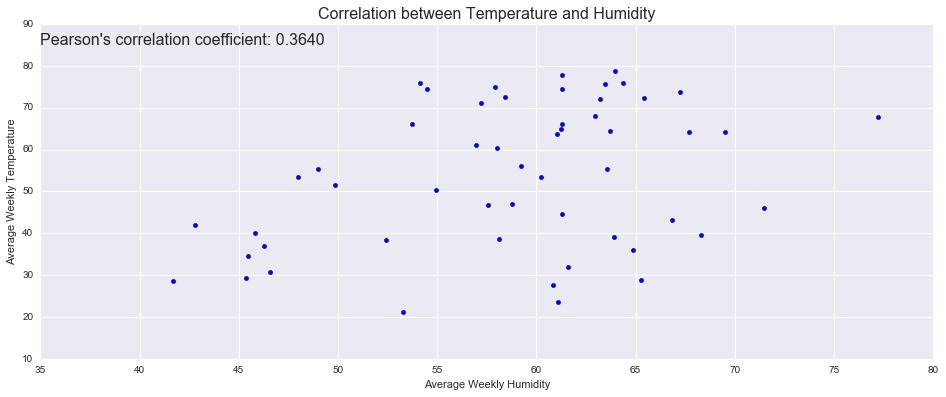

In [33]:
plt.figure(figsize=(16,6))
plt.scatter(weekly_means_humidity2014, weekly_means_temp2014)
plt.text(35,85,"Pearson's correlation coefficient: %.4f" % corr, fontsize=16)
plt.xlabel('Average Weekly Humidity')
plt.ylabel('Average Weekly Temperature')
plt.title('Correlation between Temperature and Humidity', fontsize=16)

A diagonal line would represent a pure correlation between the two variables.
In a correlation matrix with more than two variables (see [here](https://stanford.edu/~mwaskom/software/seaborn/examples/scatterplot_matrix.html) and the multiclass example below), each variable is plotted against each other. The matrix is symmetrical about the diagonal set of plots, and the diagonal set of plots represent the distribution of each variable

<img src="https://stanford.edu/~mwaskom/software/seaborn/_images/scatterplot_matrix.png" width="300">

# Forecasting
## 1) Using only weather history data from the start of 2015 on, forecast the temperature 24 hours into the future (at 15 minute intervals) from the terminating time of the weather history data.

This will be tricky. If we could forecast the weather only using statistics, NASA would stop spending money on satellites and weather balloons. 

Plus, seasonal time series can be tricky. I'll start by implementing a simple OLS model on the features I have. Then, I'll use a more complex gradient-boosted regressor. 

Finally, I'll see if I can implement an ARIMA model in statsmodels. Statsmodels 0.6 doesn't support seasonality, but I'll see how far I can get. 


Then, break off the training set:

In [34]:
history.set_index('time', inplace=True)
forecast_clean.set_index('time', inplace=True)

In [35]:
train = history[history.year == 2015][['tempi', 'hour', 'day', 'week', 'ts24', 'ts30', 'ts36', 'ts48', 'ts60', 'ts72', 'ts96']]
train.dropna(inplace=True)

I'll make the test set the first month of 2016'

In [36]:
test = history[history.year == 2016][['tempi', 'hour', 'day', 'week', 'ts24', 'ts30', 'ts36', 'ts48', 'ts60', 'ts72', 'ts96']]
test.dropna(inplace=True)

In [37]:
#build the model on our time features and autoregressive-features
features = ['hour', 'day', 'week', 'ts24', 'ts30', 'ts36', 'ts48', 'ts60', 'ts72', 'ts96']

ytrain = train.tempi
Xtrain = train[features]

ytest = test.tempi
Xtest = test[features]

In [111]:
def mape_score(true, predicted):
    '''Returns mean absolute percentage error'''
    mape = np.mean(np.abs(predicted - true)/true)
    return mape 

### OLS regression
Even though this is a time series, I'll treat the features as independent, and hyptothesize that we can predict temp just based on time of day, time of year, and previous values of temp (which we've already calculated)

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

ols = LinearRegression()
ols.fit(Xtrain, ytrain)
ols_r2_score = r2_score(ytest, ols.predict(Xtest))
ols_MSE = mean_squared_error(ytest, ols.predict(Xtest))
ols_MAPE = mape_score(ytest, ols.predict(Xtest))
test['ols_predict'] = ols.predict(Xtest) 

### Gradient Boosted Regression

In [116]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(loss='ls', n_estimators=40, max_depth=5, verbose=1, warm_start=True)
gbr_fitted = gbr.fit(Xtrain, ytrain)
gbr_r2_score = r2_score(ytest, gbr.predict(Xtest))
gbr_MSE = mean_squared_error(ytest, gbr.predict(Xtest))
gbr_MAPE = mape_score(ytest, gbr.predict(Xtest))
test['gbr_predict'] = gbr.predict(Xtest)

      Iter       Train Loss   Remaining Time 
         1         307.7798            1.32s
         2         256.7890            1.22s
         3         215.1286            1.18s
         4         181.3812            1.18s
         5         153.7243            1.19s
         6         131.2276            1.18s
         7         112.6900            1.19s
         8          97.5837            1.21s
         9          85.2822            1.20s
        10          75.2552            1.20s
        20          33.3296            0.81s
        30          24.4951            0.39s
        40          20.5388            0.00s


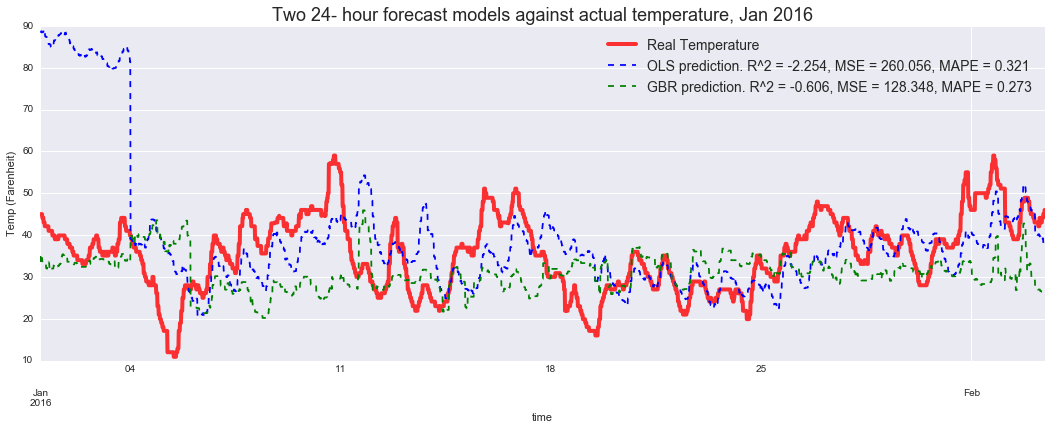

In [118]:
plt.figure(figsize=(18,6))
test['tempi'].plot(color = 'red', alpha = .8, label = 'Real Temperature', linewidth=4)
test['ols_predict'].plot(color = 'blue', label = 'OLS prediction. R^2 = {:.3f}, MSE = {:.3f}, MAPE = {:.3f}'.format(ols_r2_score, ols_MSE, ols_MAPE), linestyle='--')
test['gbr_predict'].plot(color = 'green', label = 'GBR prediction. R^2 = {:.3f}, MSE = {:.3f}, MAPE = {:.3f}'.format(gbr_r2_score, gbr_MSE, gbr_MAPE), linestyle='--')
plt.legend(fontsize=14)
plt.ylabel('Temp (Farenheit)')
plt.title('Two 24- hour forecast models against actual temperature, Jan 2016', fontsize=18)

# 2) How ’good’ is this prediction relative to the attached weather forecast dataset?

First, let's reshape the data a little. Extend the test set's time index so we can add our same autoregressive features for the date 2/4/16

In [120]:
test2 = test.copy()

ix = test2.index.append(forecast_clean.index)
test2 = test2.reindex(ix)

test2 = test2.reset_index()

test2['hour'] = test2.time.apply(lambda x: x.hour)
test2['day'] = test2.time.apply(lambda x: x.dayofyear)
test2['week'] = test2.time.apply(lambda x: x.weekofyear)
test2['month'] = test2.time.apply(lambda x: x.month)
test2['year'] = test2.time.apply(lambda x: x.year)

test2['ts24'] = test2['tempi'].shift(24*4) # 96 15-minute intervals
test2['ts30'] = test2['tempi'].shift(30*4)
test2['ts36'] = test2['tempi'].shift(36*4)
test2['ts48'] = test2['tempi'].shift(48*4)
test2['ts60'] = test2['tempi'].shift(60*4)
test2['ts72'] = test2['tempi'].shift(72*4)
test2['ts96'] = test2['tempi'].shift(96*4)


test2.set_index('time', inplace=True)

#Now, just take the subset for the period we have forecast data
test2 = test2['2/3/2016 12pm' :'2/4/2016']

#Drop out the blank columns and all remaining NAs
test2.drop('tempi', axis=1, inplace=True)
test2.drop('gbr_predict', axis=1, inplace=True)
test2.drop('ols_predict', axis=1, inplace=True)
test2.dropna(inplace=True)

#Make predictions on this new set
test2['gbr_predict'] = gbr.predict(test2[features])
test2['ols_predict'] = ols.predict(test2[features])



#Merge in the forecast data
evaluate_forecast = test2.merge(forecast_clean[['tempi']], how='left', left_index=True, right_index=True)
evaluate_forecast.rename(columns = {'tempi':'forecast'}, inplace=True)

#Evaluate the models
gbr_r2_score2 = r2_score(evaluate_forecast['forecast'], gbr.predict(evaluate_forecast[features]))
gbr_MSE2 = mean_squared_error(evaluate_forecast['forecast'], gbr.predict(test2[features]))
gbr_MAPE2 = mape_score(evaluate_forecast['forecast'], gbr.predict(evaluate_forecast[features]))

ols_r2_score2 = r2_score(evaluate_forecast['forecast'], ols.predict(evaluate_forecast[features]))
ols_MSE2 = mean_squared_error(evaluate_forecast['forecast'], ols.predict(evaluate_forecast[features]))
ols_MAPE2 = mape_score(evaluate_forecast['forecast'], ols.predict(evaluate_forecast[features]))


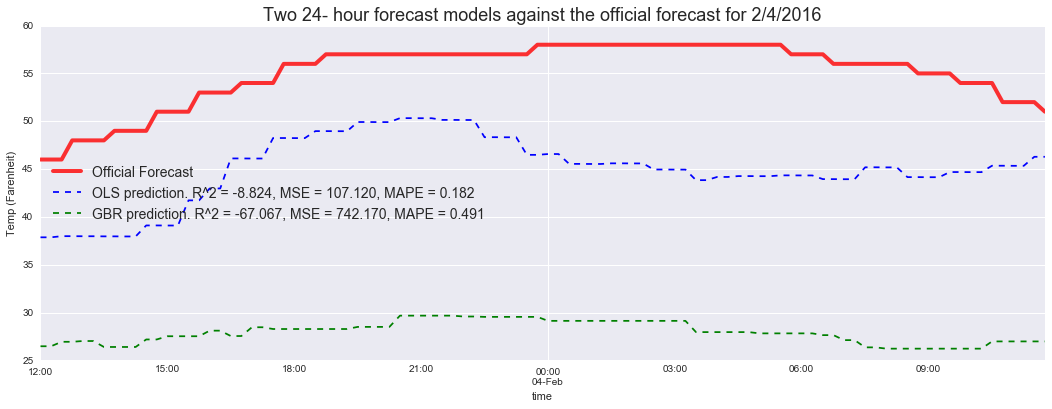

In [122]:
plt.figure(figsize=(18,6))
evaluate_forecast['forecast'].plot(color = 'red', alpha = .8, label = 'Official Forecast', linewidth=4)
evaluate_forecast['ols_predict'].plot(color = 'blue', label = 'OLS prediction. R^2 = {:.3f}, MSE = {:.3f}, MAPE = {:.3f}'.format(ols_r2_score2, ols_MSE2, ols_MAPE2), linestyle='--')
evaluate_forecast['gbr_predict'].plot(color = 'green', label = 'GBR prediction. R^2 = {:.3f}, MSE = {:.3f}, MAPE = {:.3f}'.format(gbr_r2_score2, gbr_MSE2, gbr_MAPE2), linestyle='--')
plt.legend(fontsize=14, loc='best')
plt.ylabel('Temp (Farenheit)')
plt.title('Two 24- hour forecast models against the official forecast for 2/4/2016', fontsize=18)

The simple linear regression model came closest to matching the official forecast. Its mean absolute percentage error was 18%, while the GBR model's was 49%.

# Scratch code: ARIMA model attempt

This was as far as I got with the ARIMA model, before running into problems with computing power. There's no output here, but given more time, I would have liked to find a way to optimize this model. 

Since this is a seasonal and (mostly) stationary time series, take the log of temperature and a 1-day lag

In [105]:
log_temp = train['tempi'].apply(lambda x: np.log(x))

ts_log_diff = log_temp - log_temp.shift(96) #look back 24 hours (or 96 15-min intervals)
ts_log_diff.dropna(inplace=True)

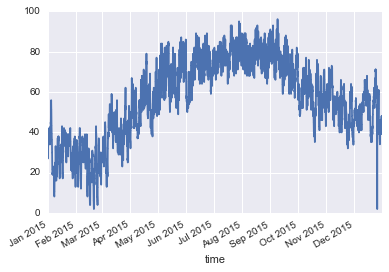

In [106]:
train['tempi'].plot()

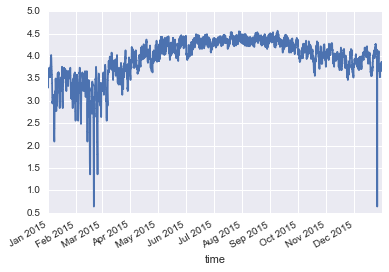

In [107]:
log_temp.plot()

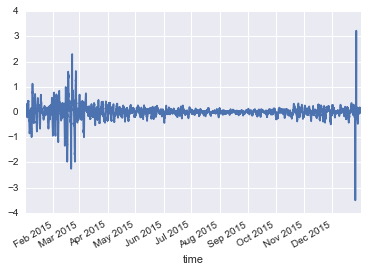

In [108]:
ts_log_diff.plot()

I want to use an ARIMA function, but I need to figure out the order to use. I'll do that using the ACF and PACF. 

Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).


Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In [109]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff[96:], nlags=80)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

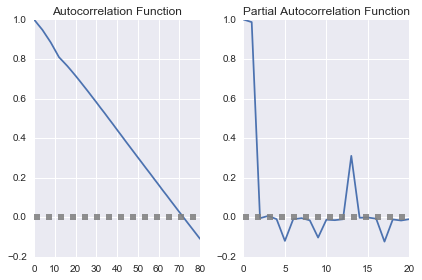

In [110]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q is large. Around 72.

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. Here, p=1



In [ ]:
## This was as far as I got here. 
The order of this model was too high

In [ ]:
arma_mod = sm.tsa.ARMA(ts_log_diff.iloc[100:], order=(1,72), freq='15M')
                
results = arma_mod.fit()

Perform a grid search to find the best model parameters:

In [ ]:
aic = []
pdq = [] 
for p in range(0,4):
    for d in range(0,1):
        for q in range(69,80):
            try: 
                arima_mod = sm.tsa.ARIMA(ts_log_diff.iloc[100:], order=(p,d,q), freq='15M')
                
                results = arima_mod.fit()
                
                x=arima_mod.aic

                x1= p,d,q
                print (x1,x)

                aic.append(x)
                pdq.append(x1)
            except:
                print p,d,q
                pass
                # ignore the error and go on